# Import Librerie

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import uuid


def outputExperiment(series, model, rmse, offset, view, image_id):
    with open("timesynth_experiment/log.txt", 'a') as f:
        result = ", ".join(map(str, list([series, model, rmse , offset , view, image_id])))
        print(result, file=f)

# Import Moduli Framework

In [3]:
from src.pipeline import Use_ARConvolutionalNeuralNetwork, Use_ARLinearRegression, Use_ARLongShortTermMemoryNeuralNetwork, Use_ARMultiLayerPerceptronNeuralNetwork, Use_ARSupportVectorRegressionLinear, Use_ARSupportVectorRegressionRBF
from src.util import ForecastingGoal, OneStepForecastingGoal, OneShotForecastingGoal
from src.performer import SlidingWindowPerformer, MinMaxTransformer, DataFrameToSeriesTransformer
from src.util.evaluation import ForecastErrorEvaluation

In [22]:
df = pd.read_csv("datasets/CASHPOINT_ID_5_GENERATED.csv")
df2 = pd.read_csv("datasets/CASHPOINT_ID_5.csv")

In [23]:
df = df.sort_values("DT_REFERENCE")
df["DT_REFERENCE"] = pd.to_datetime(df["DT_REFERENCE"]).dt.date
df2 = df2.sort_values("DT_REFERENCE")
df2["DT_REFERENCE"] = pd.to_datetime(df2["DT_REFERENCE"]).dt.date

In [24]:
df = df.groupby("DT_REFERENCE").mean()
df2 = df2.groupby("DT_REFERENCE").sum()

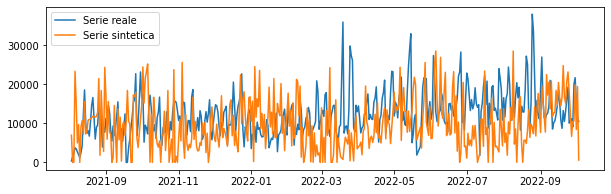

In [30]:
plt.figure(figsize=(10,3))
plt.plot(df2)
plt.plot(df)
plt.legend(["Serie reale","Serie sintetica" ])

# Serie Sintetica SD1

In [3]:
df = pd.read_csv("datasets/CASHPOINT_ID_5.csv")
sd1 = df["SERIES1"]
sd1 = MinMaxTransformer.transform(sd1.to_numpy())
size_sd1 = int(len(sd1) * .8)
test_sd1= sd1[size_sd1::]
sd1 = sd1[0:size_sd1]

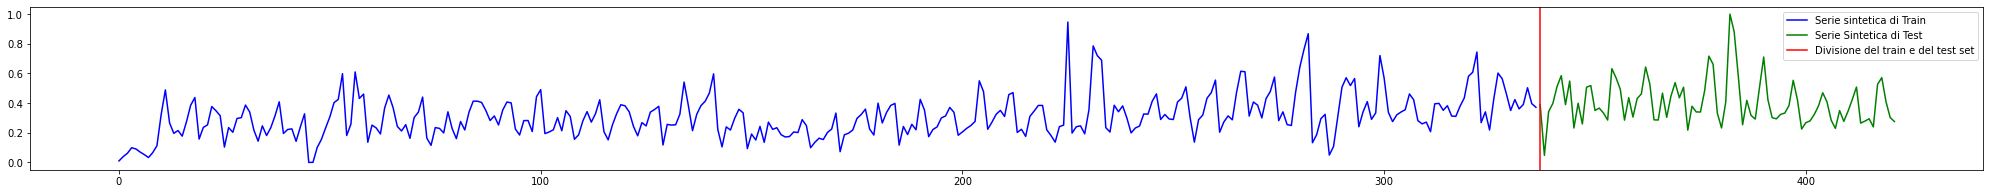

In [4]:
plt.figure(figsize=(35,3))
plt.plot(sd1, 'blue')
plt.plot(np.arange(len(test_sd1))+len(sd1), test_sd1, 'g')
plt.axvline(x=len(sd1), color="red")
plt.legend(["Serie sintetica di Train", "Serie Sintetica di Test", "Divisione del train e del test set"])

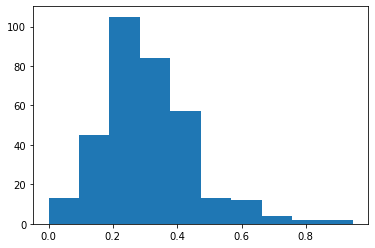

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

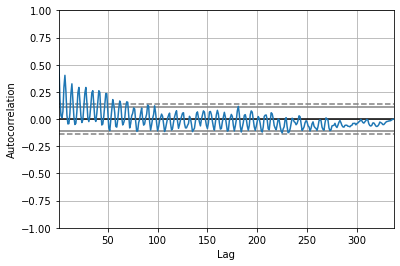

In [5]:
plt.hist(sd1)
plt.show()
pd.plotting.autocorrelation_plot(sd1)

# Serie Sintetica SD2

In [6]:
# df2 = pd.read_csv("synthetic_dataset/sd2.csv")
# sd2 = df2["sd2(t)"]
# sd2 = MinMaxTransformer.transform(sd2.to_numpy())
# size_sd2 = int(len(sd2) * .8)
# test_sd2 = sd2[size_sd2::]
# sd2 = sd2[0:size_sd2]

In [7]:
# plt.figure(figsize=(35,3))
# plt.plot(sd2, 'blue')
# plt.plot(np.arange(len(test_sd2))+len(sd2), test_sd2, 'g')
# plt.axvline(x=len(sd2), color="red")
# plt.legend(["Serie sintetica di Train", "Serie Sintetica di Test", "Divisione del train e del test set"])

In [8]:
# plt.hist(sd2)
# plt.show()
# pd.plotting.autocorrelation_plot(sd2)

NameError: name 'sd2' is not defined

# One Step Forecasting

In [ ]:
offset = 3
series = sd1
test_series = test_sd1
size = size_sd1
goal = OneStepForecastingGoal(offset=offset)

## Esecuzione del Framework

### AR Linear Regression

In [ ]:
ar_linear_regression, ar_linear_regression_parameters, ar_linear_regression_loss = Use_ARLinearRegression().__execute__(series = series, goal=goal)
ar_linear_regression_loss = f'{ar_linear_regression_loss:.5f}'
fl = ar_linear_regression_parameters['feature_length']
print("RMSE:", ar_linear_regression_loss)
print("AR LAG VARIABLES SIZE:", fl)

In [ ]:
SWP = SlidingWindowPerformer(feature_length=fl, target_length=1, target_offset=offset)
_, Xt, Yt = SWP.get(series)
_, X, Y = SWP.get(test_series)
yhat_train = ar_linear_regression.__test__(Xt)
yhat = ar_linear_regression.__test__(X)
error = ForecastErrorEvaluation(goal = goal).get(Y, yhat)
print("RMSE:", error)

In [ ]:
plt.figure(figsize=(35,3))
plt.plot(Yt)
plt.plot(yhat_train, linestyle="--")
plt.plot(np.arange(len(Y))+len(Yt), Y)
plt.plot(np.arange(len(Y))+len(Yt), yhat, linestyle="--")
plt.axvline(x=len(Yt), color="red")
plt.legend(["Train Set", "Train Set Prediction", "Test Set", "Test Set Prediction", "Test - Train Splitter"])

image_name = uuid.uuid1().__str__()
outputExperiment("experiment_1", "AR_LinearRegression", error, offset, 1, image_name)
plt.savefig("timesynth_experiment/"+image_name)

### AR Support Vector Linear Regression

In [ ]:
import warnings
warnings.filterwarnings('ignore')
ar_svr_linear_regression, ar_svr_linear_regression_parameters, ar_svr_linear_regression_loss = Use_ARSupportVectorRegressionLinear().__execute__(series = series, goal=goal)
ar_svr_linear_regression_loss = f'{ar_svr_linear_regression_loss:.5f}'
fl = ar_svr_linear_regression_parameters['feature_length']
c = ar_svr_linear_regression_parameters['C']
epsilon = ar_svr_linear_regression_parameters['epsilon']
fit_intercept = ar_svr_linear_regression_parameters['fit_intercept']
print("RMSE:", ar_svr_linear_regression_loss)
print("AR LAG VARIABLES SIZE:", fl)
print("C:", c)
print("EPSILON:", epsilon)
print("FIT_INTERCEPT:", fit_intercept)

In [ ]:
SWP = SlidingWindowPerformer(feature_length=fl, target_length=1, target_offset=offset)
_, Xt, Yt = SWP.get(series)
_, X, Y = SWP.get(test_series)
yhat_train = ar_svr_linear_regression.__test__(Xt)
yhat = ar_svr_linear_regression.__test__(X)
error = ForecastErrorEvaluation(goal = goal).get(Y, yhat)
print("RMSE:", error)

In [ ]:
plt.figure(figsize=(35,3))
plt.plot(Yt)
plt.plot(yhat_train, linestyle="--")
plt.plot(np.arange(len(Y))+len(Yt), Y)
plt.plot(np.arange(len(Y))+len(Yt), yhat, linestyle="--")
plt.axvline(x=len(Yt), color="red")
plt.legend(["Train Set", "Train Set Prediction", "Test Set", "Test Set Prediction", "Test - Train Splitter"])

image_name = uuid.uuid1().__str__()
outputExperiment("experiment_1", "AR_Linear_SupportVectorRegression", error, offset, 1, image_name)
plt.savefig("timesynth_experiment/"+image_name)

### AR Support Vector RBF Regression

In [ ]:
import warnings
warnings.filterwarnings('ignore')
ar_svr_rbf_regression, ar_svr_rbf_regression_parameters, ar_svr_rbf_regression_loss = Use_ARSupportVectorRegressionRBF().__execute__(series = series, goal=goal)
ar_svr_rbf_regression_loss = f'{ar_svr_rbf_regression_loss:.5f}'
fl = ar_svr_rbf_regression_parameters['feature_length']
c = ar_svr_rbf_regression_parameters['C']
epsilon = ar_svr_rbf_regression_parameters['epsilon']
gamma = ar_svr_rbf_regression_parameters['gamma']
print("RMSE:", ar_svr_rbf_regression_loss)
print("AR LAG VARIABLES SIZE:", fl)
print("C:", c)
print("EPSILON:", epsilon)
print("GAMMA:", gamma)

In [ ]:
SWP = SlidingWindowPerformer(feature_length=fl, target_length=1, target_offset=offset)
_, Xt, Yt = SWP.get(series)
_, X, Y = SWP.get(test_series)
yhat_train = ar_svr_rbf_regression.__test__(Xt)
yhat = ar_svr_rbf_regression.__test__(X)
error = ForecastErrorEvaluation(goal = goal).get(Y, yhat)
print("RMSE:", error)

In [ ]:
plt.figure(figsize=(35,3))
plt.plot(Yt)
plt.plot(yhat_train, linestyle="--")
plt.plot(np.arange(len(Y))+len(Yt), Y)
plt.plot(np.arange(len(Y))+len(Yt), yhat, linestyle="--")
plt.axvline(x=len(Yt), color="red")
plt.legend(["Train Set", "Train Set Prediction", "Test Set", "Test Set Prediction", "Test - Train Splitter"])

image_name = uuid.uuid1().__str__()
outputExperiment("experiment_1", "AR_RBF_SupportVectorRegression", error, offset, 1, image_name)
plt.savefig("timesynth_experiment/"+image_name)

### AR Multi Layer Perceptron

In [ ]:
ar_mlp_nn, ar_mlp_nn_parameters, ar_mlp_nn_loss = Use_ARMultiLayerPerceptronNeuralNetwork().__execute__(series = series, goal=goal)
ar_mlp_nn_loss = f'{ar_mlp_nn_loss:.5f}'
fl = ar_mlp_nn_parameters['feature_length']
print("RMSE:", ar_mlp_nn_loss)
print("AR LAG VARIABLES SIZE:", fl)

In [ ]:
ar_mlp_nn.eval()
with torch.no_grad():
    SWP = SlidingWindowPerformer(feature_length=fl, target_length=1, target_offset=offset)
    _, Xt, Yt = SWP.get(series)
    _, X, Y = SWP.get(test_series)
    yhat_train = ar_mlp_nn(torch.tensor(Xt))
    yhat = ar_mlp_nn(torch.tensor(X))
    error = ForecastErrorEvaluation(goal = goal).get(torch.tensor(Y), yhat)
    print("RMSE:", error.item())

In [ ]:
plt.figure(figsize=(35,3))
plt.plot(Yt)
plt.plot(yhat_train.detach().numpy(), linestyle="--")
plt.plot(np.arange(len(Y))+len(Yt), Y)
plt.plot(np.arange(len(Y))+len(Yt), yhat.detach().numpy(), linestyle="--")
plt.axvline(x=len(Yt), color="red")
plt.legend(["Train Set", "Train Set Prediction", "Test Set", "Test Set Prediction", "Test - Train Splitter"])

image_name = uuid.uuid1().__str__()
outputExperiment("experiment_1", "AR_NN_MultiLayerPerceptron", error, offset, 1, image_name)
plt.savefig("timesynth_experiment/"+image_name)

### AR Long Short Memory

In [ ]:
ar_lstm_nn, ar_lstm_nn_parameters, ar_lstm_nn_loss = Use_ARLongShortTermMemoryNeuralNetwork().__execute__(series = series, goal=goal)
ar_lstm_nn_loss = f'{ar_lstm_nn_loss:.5f}'
fl = ar_lstm_nn_parameters['feature_length']
print("RMSE:", ar_lstm_nn_loss)
print("AR LAG VARIABLES SIZE:", fl)

In [ ]:
ar_lstm_nn.eval()
with torch.no_grad():
    SWP = SlidingWindowPerformer(feature_length=fl, target_length=1, target_offset=offset)
    _, Xt, Yt = SWP.get(series)
    _, X, Y = SWP.get(test_series)
    yhat_train = ar_lstm_nn(torch.tensor(Xt))
    yhat = ar_lstm_nn(torch.tensor(X))
    error = ForecastErrorEvaluation(goal = goal).get(torch.tensor(Y), yhat)
    print("RMSE:", error.item())

In [ ]:
plt.figure(figsize=(35,3))
plt.plot(Yt)
plt.plot(yhat_train.detach().numpy(), linestyle="--")
plt.plot(np.arange(len(Y))+len(Yt), Y)
plt.plot(np.arange(len(Y))+len(Yt), yhat.detach().numpy(), linestyle="--")
plt.axvline(x=len(Yt), color="red")
plt.legend(["Train Set", "Train Set Prediction", "Test Set", "Test Set Prediction", "Test - Train Splitter"])

image_name = uuid.uuid1().__str__()
outputExperiment("experiment_1", "AR_NN_LongShortMemory", error, offset, 1, image_name)
plt.savefig("timesynth_experiment/"+image_name)

### AR Convolutional Neural Network

In [ ]:
ar_cnn_nn, ar_cnn_nn_parameters, ar_cnn_nn_loss = Use_ARConvolutionalNeuralNetwork().__execute__(series = series, goal=goal)
ar_cnn_nn_loss = f'{ar_cnn_nn_loss:.5f}'
fl = ar_cnn_nn_parameters['feature_length']
print("RMSE:", ar_cnn_nn_loss)
print("AR LAG VARIABLES SIZE:", fl)

In [ ]:
ar_cnn_nn.eval()
with torch.no_grad():
    SWP = SlidingWindowPerformer(feature_length=fl, target_length=1, target_offset=offset)
    _, Xt, Yt = SWP.get(series)
    _, X, Y = SWP.get(test_series)
    yhat_train = ar_cnn_nn(torch.tensor(Xt))
    yhat = ar_cnn_nn(torch.tensor(X))
    error = ForecastErrorEvaluation(goal = goal).get(torch.tensor(Y), yhat)
    print("RMSE:", error.item())

In [ ]:
plt.figure(figsize=(35,3))
plt.plot(Yt)
plt.plot(yhat_train.detach().numpy(), linestyle="--")
plt.plot(np.arange(len(Y))+len(Yt), Y)
plt.plot(np.arange(len(Y))+len(Yt), yhat.detach().numpy(), linestyle="--")
plt.axvline(x=len(Yt), color="red")
plt.legend(["Train Set", "Train Set Prediction", "Test Set", "Test Set Prediction", "Test - Train Splitter"])

image_name = uuid.uuid1().__str__()
outputExperiment("experiment_1", "AR_NN_ConvolutionalNeuralNetwork", error, offset, 1, image_name)
plt.savefig("timesynth_experiment/"+image_name)

# One Shot Forecasting

In [ ]:
offset = 1
view = 3
series = sd1
test_series = test_sd1
size = size_sd1
goal = OneShotForecastingGoal(offset=offset, view=view)

In [ ]:
def RMSE_Loss(actual, predicted):
    """Root Mean Squared Error"""
    return np.sqrt(np.mean(np.square(actual - predicted)))

## Esecuzione del Framework

### AR Linear Regression

In [ ]:
ar_linear_regression, ar_linear_regression_parameters, ar_linear_regression_loss = Use_ARLinearRegression().__execute__(series = series, goal=goal)
ar_linear_regression_loss = f'{ar_linear_regression_loss:.5f}'
fl = ar_linear_regression_parameters['feature_length']
print("RMSE:", ar_linear_regression_loss)
print("AR LAG VARIABLES SIZE:", fl)

In [ ]:
SWP = SlidingWindowPerformer(feature_length=fl, target_length=view, target_offset=offset)
_, Xt, Yt = SWP.get(series)
_, X, Y = SWP.get(test_series)
yhat_train = ar_linear_regression.__test__(Xt)
yhat = ar_linear_regression.__test__(X)

series_Yt = DataFrameToSeriesTransformer.transform(Yt)
series_yhat_train = DataFrameToSeriesTransformer.transform(yhat_train)
series_Y = DataFrameToSeriesTransformer.transform(Y)
series_yhat = DataFrameToSeriesTransformer.transform(yhat)
error = RMSE_Loss(np.array(series_Y), np.array(series_yhat))
print(error)

In [ ]:
plt.figure(figsize=(35,3))
plt.plot(series_Yt)
plt.plot(series_yhat_train, linestyle="--")
plt.plot(np.arange(len(series_Y))+len(series_Yt), series_Y)
plt.plot(np.arange(len(series_Y))+len(series_Yt), series_yhat, linestyle="--")
plt.axvline(x=len(series_Yt), color="red")
plt.legend(["Train Set", "Train Set Prediction", "Test Set", "Test Set Prediction", "Test - Train Splitter"])

image_name = uuid.uuid1().__str__()
outputExperiment("experiment_1", "AR_LinearRegression", error, offset, view, image_name)
plt.savefig("timesynth_experiment/"+image_name)

### AR Multi Layer Perceptron

In [ ]:
ar_mlp_nn, ar_mlp_nn_parameters, ar_mlp_nn_loss = Use_ARMultiLayerPerceptronNeuralNetwork().__execute__(series = series, goal=goal)
ar_mlp_nn_loss = f'{ar_mlp_nn_loss:.5f}'
fl = ar_mlp_nn_parameters['feature_length']
print("RMSE:", ar_mlp_nn_loss)
print("AR LAG VARIABLES SIZE:", fl)

In [ ]:
ar_mlp_nn.eval()
with torch.no_grad():
    SWP = SlidingWindowPerformer(feature_length=fl, target_length=1, target_offset=offset)
    _, Xt, Yt = SWP.get(series)
    _, X, Y = SWP.get(test_series)
    yhat_train = ar_mlp_nn(torch.tensor(Xt))
    yhat = ar_mlp_nn(torch.tensor(X))
    error = ForecastErrorEvaluation(goal = goal).get(torch.tensor(Y), yhat)
    series_Yt = DataFrameToSeriesTransformer.transform(Yt)
    series_yhat_train = DataFrameToSeriesTransformer.transform(yhat_train.detach().numpy())
    series_Y = DataFrameToSeriesTransformer.transform(Y)
    series_yhat = DataFrameToSeriesTransformer.transform(yhat.detach().numpy())
    error = RMSE_Loss(np.array(series_Y), np.array(series_yhat))
    print(error)

In [ ]:
plt.figure(figsize=(35,3))
plt.plot(series_Yt)
plt.plot(series_yhat_train, linestyle="--")
plt.plot(np.arange(len(series_Y))+len(series_Yt), series_Y)
plt.plot(np.arange(len(series_Y))+len(series_Yt), series_yhat, linestyle="--")
plt.axvline(x=len(series_Yt), color="red")
plt.legend(["Train Set", "Train Set Prediction", "Test Set", "Test Set Prediction", "Test - Train Splitter"])

image_name = uuid.uuid1().__str__()
outputExperiment("experiment_1", "AR_NN_MultiLayerPerceptron", error, offset, view, image_name)
plt.savefig("timesynth_experiment/"+image_name)

### AR Convolutional Network

In [ ]:
ar_cnn_nn, ar_cnn_nn_parameters, ar_cnn_nn_loss = Use_ARConvolutionalNeuralNetwork().__execute__(series = series, goal=goal)
ar_cnn_nn_loss = f'{ar_cnn_nn_loss:.5f}'
fl = ar_cnn_nn_parameters['feature_length']
print("RMSE:", ar_cnn_nn_loss)
print("AR LAG VARIABLES SIZE:", fl)

In [ ]:
ar_cnn_nn.eval()
with torch.no_grad():
    SWP = SlidingWindowPerformer(feature_length=fl, target_length=1, target_offset=offset)
    _, Xt, Yt = SWP.get(series)
    _, X, Y = SWP.get(test_series)
    yhat_train = ar_cnn_nn(torch.tensor(Xt))
    yhat = ar_cnn_nn(torch.tensor(X))
    error = ForecastErrorEvaluation(goal = goal).get(torch.tensor(Y), yhat)
    series_Yt = DataFrameToSeriesTransformer.transform(Yt)
    series_yhat_train = DataFrameToSeriesTransformer.transform(yhat_train.detach().numpy())
    series_Y = DataFrameToSeriesTransformer.transform(Y)
    series_yhat = DataFrameToSeriesTransformer.transform(yhat.detach().numpy())
    error = RMSE_Loss(np.array(series_Y), np.array(series_yhat))
    print(error)

In [ ]:
plt.figure(figsize=(35,3))
plt.plot(series_Yt)
plt.plot(series_yhat_train, linestyle="--")
plt.plot(np.arange(len(series_Y))+len(series_Yt), series_Y)
plt.plot(np.arange(len(series_Y))+len(series_Yt), series_yhat, linestyle="--")
plt.axvline(x=len(series_Yt), color="red")
plt.legend(["Train Set", "Train Set Prediction", "Test Set", "Test Set Prediction", "Test - Train Splitter"])

image_name = uuid.uuid1().__str__()
outputExperiment("experiment_1", "AR_NN_ConvolutionalNeuralNetwork", error, offset, view, image_name)
plt.savefig("timesynth_experiment/"+image_name)

### AR Long Short Term Memory

In [ ]:
ar_lstm_nn, ar_lstm_nn_parameters, ar_lstm_nn_loss = Use_ARLongShortTermMemoryNeuralNetwork().__execute__(series = series, goal=goal)
ar_lstm_nn_loss = f'{ar_lstm_nn_loss:.5f}'
fl = ar_lstm_nn_parameters['feature_length']
print("RMSE:", ar_lstm_nn_loss)
print("AR LAG VARIABLES SIZE:", fl)

In [ ]:
ar_lstm_nn.eval()
with torch.no_grad():
    SWP = SlidingWindowPerformer(feature_length=fl, target_length=1, target_offset=offset)
    _, Xt, Yt = SWP.get(series)
    _, X, Y = SWP.get(test_series)
    yhat_train = ar_lstm_nn(torch.tensor(Xt))
    yhat = ar_lstm_nn(torch.tensor(X))
    error = ForecastErrorEvaluation(goal = goal).get(torch.tensor(Y), yhat)
    series_Yt = DataFrameToSeriesTransformer.transform(Yt)
    series_yhat_train = DataFrameToSeriesTransformer.transform(yhat_train.detach().numpy())
    series_Y = DataFrameToSeriesTransformer.transform(Y)
    series_yhat = DataFrameToSeriesTransformer.transform(yhat.detach().numpy())
    error = RMSE_Loss(np.array(series_Y), np.array(series_yhat))
    print(error)

In [ ]:
plt.figure(figsize=(35,3))
plt.plot(series_Yt)
plt.plot(series_yhat_train, linestyle="--")
plt.plot(np.arange(len(series_Y))+len(series_Yt), series_Y)
plt.plot(np.arange(len(series_Y))+len(series_Yt), series_yhat, linestyle="--")
plt.axvline(x=len(series_Yt), color="red")
plt.legend(["Train Set", "Train Set Prediction", "Test Set", "Test Set Prediction", "Test - Train Splitter"])

image_name = uuid.uuid1().__str__()
outputExperiment("experiment_1", "AR_NN_LongShortMemory", error, offset, view, image_name)
plt.savefig("timesynth_experiment/"+image_name)